In [ ]:
# https://github.com/JohannesBuchner/imagehash
!pip install imagehash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 296 kB 14.6 MB/s 


In [ ]:
# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

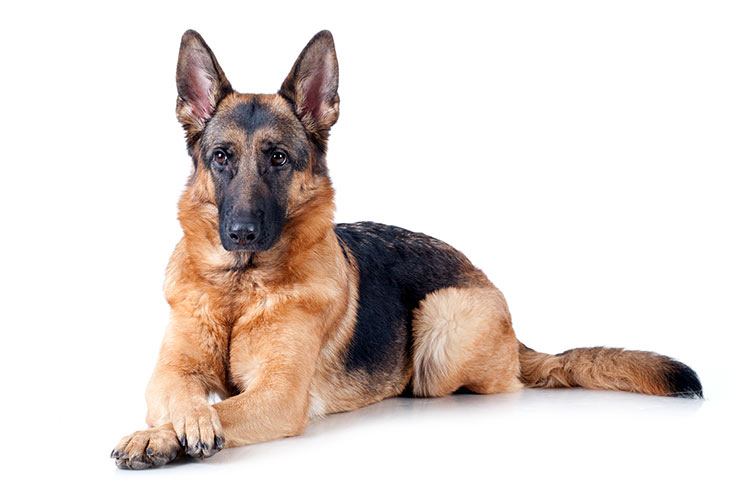

In [ ]:
from PIL import Image
import skimage.io as io

# Initialize Img2Vec without GPU
img2vec = Img2Vec(cuda=False)

# Read in an image
doggo_img_1 = Image.fromarray(io.imread('https://raw.githubusercontent.com/andandandand/intro-computer-vision/main/images/German-Shepherd-on-White-00.jpg?token=AAHZIX53PGS6RH6URUERVTLAH745I'))
# Get a vector from img2vec, returned as a numpy array
doggo_img_1

In [ ]:
doggo_vec_1 = img2vec.get_vec(doggo_img_1, tensor=False)
# check out the vector's shape and its contents
doggo_vec_1.shape, doggo_vec_1[:10]

((512,), array([1.1052316 , 0.00715564, 0.9495527 , 0.6432267 , 0.21712479,
        2.3215783 , 0.34361437, 0.70317173, 0.07304046, 1.695864  ],
       dtype=float32))

In [ ]:
doggo_vec_1 >= doggo_vec_1.mean()

array([ True, False, False, False, False,  True, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
        True,  True,  True, False, False,  True, False,  True, False,
        True, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False, False,  True,  True, False, False, False,  True,
       False,  True, False,  True, False, False,  True,  True, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True, False, False,  True, False,  True,  True,
        True, False,  True, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True, False, False, False, False,
       False,  True, False,  True, False, False,  True,  True, False,
       False, False,

In [ ]:
# we also create a perceptual hash
import imagehash

doggo_hash_1 = imagehash.crop_resistant_hash(doggo_img_1)
doggo_hash_1

[array([[False, False,  True, False,  True, False, False, False],
       [False, False, False,  True,  True, False,  True, False],
       [ True, False, False,  True,  True, False,  True, False],
       [ True, False, False,  True,  True,  True, False,  True],
       [ True, False, False, False,  True,  True, False, False],
       [ True, False,  True, False,  True,  True,  True,  True],
       [False, False,  True, False,  True,  True, False,  True],
       [False, False,  True,  True, False, False, False, False]]), array([[ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False,  True],
       [ True, False, False,  True,  True, False, False,  True],
       [False, False,  True, False, False,  True, False,  True],
       [False, False,  True, False, False,  True, False,  True],
       [False, False,  True, False, False,  True,  True,  True],
       [ True, False, False, False,  True,  True,  True,  True],
       [ True, False, 

In [ ]:
from numpy import dot
from numpy.linalg import norm

#https://stackoverflow.com/a/43043160/45963
def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

#https://stackoverflow.com/a/1401828/45963
def euclidean_distance(a, b):
  return norm(a-b)

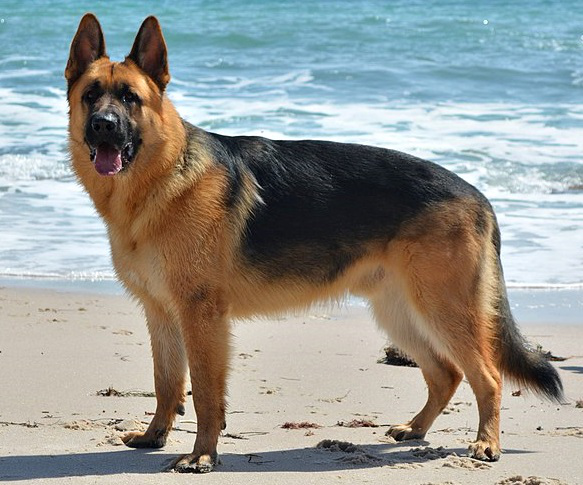

In [ ]:
# Read in an image
doggo_img_2 = Image.fromarray(io.imread('https://raw.githubusercontent.com/andandandand/intro-computer-vision/main/images/German_Shepherd_-_DSC_0346_(10096362833).jpg?token=AAHZIX5PROKWHM5RGEJWZS3AH76E6'))
# Get a vector from img2vec, returned as a numpy array
doggo_img_2

In [ ]:
doggo_vec_2 = img2vec.get_vec(doggo_img_2, tensor=False)
doggo_vec_2.shape, doggo_vec_2[:10]

((512,), array([0.4740334 , 0.27971283, 0.6391162 , 0.26638713, 1.1095537 ,
        1.6593446 , 0.9750598 , 1.3243165 , 0.4164774 , 1.1993315 ],
       dtype=float32))

In [ ]:
# https://github.com/JohannesBuchner/imagehash
# https://www.pyimagesearch.com/2017/11/27/image-hashing-opencv-python/
doggo_hash_2 = imagehash.crop_resistant_hash(doggo_img_2)
doggo_hash_2

[array([[False,  True,  True, False,  True, False,  True,  True],
       [False,  True,  True, False,  True, False, False, False],
       [False,  True,  True, False,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False,  True, False,  True,  True],
       [ True, False, False,  True, False, False, False,  True],
       [ True, False,  True,  True, False, False, False,  True],
       [False, False,  True,  True, False,  True,  True,  True]]), array([[ True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False,  True],
       [ True, False, False, False, False,  True, False, False],
       [ True, False, False, False,  True, False, False, False],
       [ True, False,  True,  True,  True,  True,  True, False],
       [ True, False,  True, False, False,  True,  True, False],
       [ True, False, False,  True, False, False, False, False],
       [ True, False, 

In [ ]:
# the Hamming distance between these images can be obtained by using the minus operator
# between the two hashes, this represents the number of bit flips between the two matrices 
doggo_hash_1 - doggo_hash_2, doggo_hash_2 - doggo_hash_1

(4, 4)

In [ ]:
import matplotlib.pyplot as plt
# utility function to show images side to side
def show_pair(imag_a, imag_b): 
  plt.subplot(121)
  plt.imshow(np.array(imag_a))
  plt.axis("off")
  
  plt.subplot(122)
  plt.imshow(np.array(imag_b))
  plt.axis("off")


cosine similarity = 0.7787
Euclidean distance = 19.1978
Hamming distance = 4


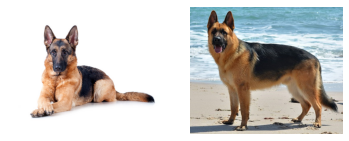

In [ ]:
# Code refactoring exercise: given a pair of PIL images as input, output the cosine similarity, 
# Euclidean distance, Hamming distance and the pair of images side by side
show_pair(doggo_img_1, doggo_img_2)
print(f'cosine similarity = {cosine_similarity(doggo_vec_2, doggo_vec_1):.4f}')
print(f'Euclidean distance = {euclidean_distance(doggo_vec_2, doggo_vec_1):.4f}')
print(f'Hamming distance = {(doggo_hash_1 - doggo_hash_2)}')

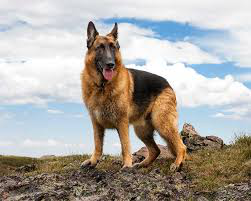

In [ ]:
# Read in an image
doggo_img_3 = Image.fromarray(io.imread('https://raw.githubusercontent.com/andandandand/intro-computer-vision/main/images/german_shepherd.jpeg?token=AAHZIX6HMVGE4I5XY7CNQKLAH76KK'))
# Get a vector from img2vec, returned as a numpy array
doggo_img_3

In [ ]:
import PIL 

def evaluate_similarity(imag_1:PIL.Image, imag_2:PIL.Image):
  img2vec = Img2Vec()

  vec_1 = img2vec.get_vec(imag_1, tensor=False)
  vec_2 = img2vec.get_vec(imag_2, tensor=False)

  hash_1 = imagehash.crop_resistant_hash(imag_1)
  hash_2 = imagehash.crop_resistant_hash(imag_2)

  print(f'cosine similarity = {cosine_similarity(vec_2, vec_1):.4f}')
  print(f'Euclidean distance = {euclidean_distance(vec_2, vec_1):.4f}')
  print(f'Hamming distance = {(hash_1 - hash_2)}')
  
  show_pair(imag_1, imag_2)

cosine similarity = 0.8508
Euclidean distance = 15.0001
Hamming distance = 4


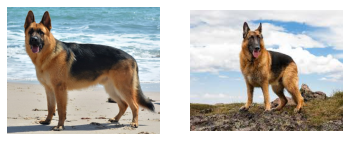

In [ ]:
evaluate_similarity(doggo_img_2, doggo_img_3)


## Testing on near-duplicates using Albumentations

In [ ]:
import cv2
from matplotlib import pyplot as plt
from albumentations import(RandomSizedCrop)

from random import seed
from random import random
# seed random number generator


import math
def get_pct_pixels(imag, crop_pct):
  
  #normal case: width greater than height
  if imag.shape[1] > imag.shape[0]:
    pixels_to_crop_from_height = math.floor((imag.shape[0] / 100) * crop_pct)
    pixels_to_crop_from_width = math.floor((imag.shape[1] / 100) * crop_pct)
  else:
    pixels_to_crop_from_height = math.floor((imag.shape[1] / 100) * crop_pct)
    pixels_to_crop_from_width = math.floor((imag.shape[0] / 100) * crop_pct)
  return pixels_to_crop_from_height, pixels_to_crop_from_width

def do_random_sized_crop(imag, crop_pct):
  
  print('shape of image before crop = {}'.format(imag.shape))
  crop_height_pixels, crop_width_pixels = get_pct_pixels(imag, crop_pct)
  
  cropped_image_height = imag.shape[0] - crop_height_pixels
  cropped_image_width  = imag.shape[1] - crop_width_pixels
  
  min_max_height = (cropped_image_height - 10, cropped_image_height) 
  
  print(f'min_max_height = {min_max_height}, cropped_image_height = {cropped_image_height}, cropped_image_width = {cropped_image_width}')
  seed(42)
  aug = RandomSizedCrop(min_max_height, cropped_image_height, cropped_image_width)
  
  cropped_image = aug(image=imag)['image']
  
  print(f'cropped image shape = {cropped_image.shape}')
  
  return(cropped_image)

shape of image before crop = (486, 729, 3)
min_max_height = (428, 438), cropped_image_height = 438, cropped_image_width = 657
cropped image shape = (438, 657, 3)


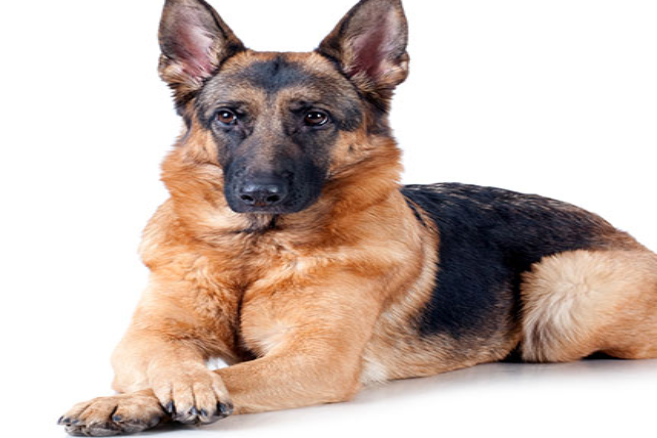

In [ ]:

doggo_img1_random_crop = Image.fromarray(do_random_sized_crop(np.array(doggo_img_1), 10))
doggo_vec1_random_crop = img2vec.get_vec(doggo_img1_random_crop, tensor=False)
doggo_img1_random_crop

'cosine similarity = 0.9486'

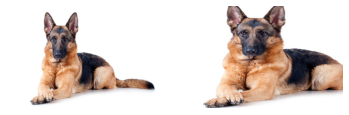

In [ ]:
show_pair(np.array(doggo_img_1), np.array(doggo_img1_random_crop))
f'cosine similarity = {cosine_similarity(doggo_vec1_random_crop, doggo_vec_1):.4f}'

In [ ]:
cosine_similarity(doggo_vec1_random_crop, doggo_vec_1)

0.94861794

In [ ]:
#https://github.com/albumentations-team/albumentations#a-simple-example
import albumentations as A
import cv2

# Declare an augmentation pipeline
transform = A.Compose([
            A.CenterCrop(224,224),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            A.Cutout(p=0.5)
])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/dropout/cutout.py:52: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


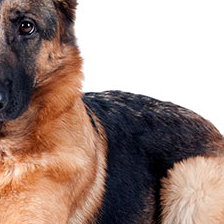

In [ ]:
# try evaluating this same cell multiple times

# albumentations expects an RGB array as input  
transformed = transform(image=np.array(doggo_img_1))
transformed_image = transformed["image"]
#Image.fromarray(numpy_array) allows us to go back to PIL format
augmented_doggo_img_1 = Image.fromarray(transformed_image)
augmented_doggo_img_1

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cosine similarity = 0.8791
Euclidean distance = 14.8768
Hamming distance = 4


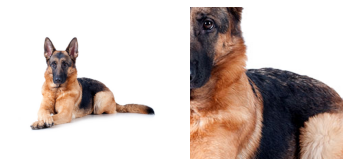

In [ ]:
evaluate_similarity(doggo_img_1, augmented_doggo_img_1)  